###Imports

In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

###Using a TensorFlow Hub MobileNet for prediction

Download the MobileNet model and create a Keras model from it. MobileNet is expecting images of 224  ×  224 pixels, in 3 color channels (RGB).



In [4]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

###Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

61306/61306 [==============================] - 0s 0us/step


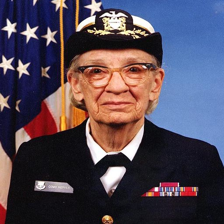

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

 models always want a batch of images to process. So here, we add a batch dimension, and pass the image to the model for prediction.

In [7]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 10s 10s/step


(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Decode the predictions

To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

10484/10484 [==============================] - 0s 1us/step


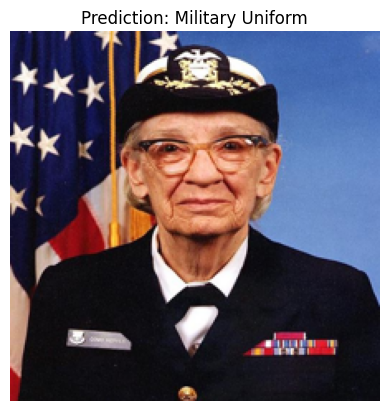

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

WOOHOO Our model correctly predicted military uniform!

###Now we'll use the full MobileNet model and see how it can perform on the Dogs vs. Cats dataset.

In [10]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteMIKF16/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


The images in the Dogs vs. Cats dataset are not all the same size.

In [11]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


###so we need to reformat all images to the resolution expected by MobileNet (224, 224).

In [12]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

###Running the classifier on a batch of images

In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

1/1 [==============================] - 1s 756ms/step


array(['tabby', 'Egyptian cat', 'tabby', 'Border collie', 'Egyptian cat',
       'Egyptian cat', 'Pekinese', 'tabby', 'tabby', 'keeshond',
       'Persian cat', 'standard schnauzer', 'Siamese cat', 'tiger cat',
       'kelpie', 'Egyptian cat', 'black-and-tan coonhound',
       'Siberian husky', 'Saluki', 'dingo', 'tabby', 'chow',
       'Sealyham terrier', 'tabby', 'tabby', 'bluetick', 'Appenzeller',
       'beagle', 'Pembroke', 'German shepherd', 'Egyptian cat',
       'Persian cat'], dtype='<U30')

The labels seem to match names of Dogs and Cats. Let's now plot the images from our Dogs vs Cats dataset and put the ImageNet labels next to them.



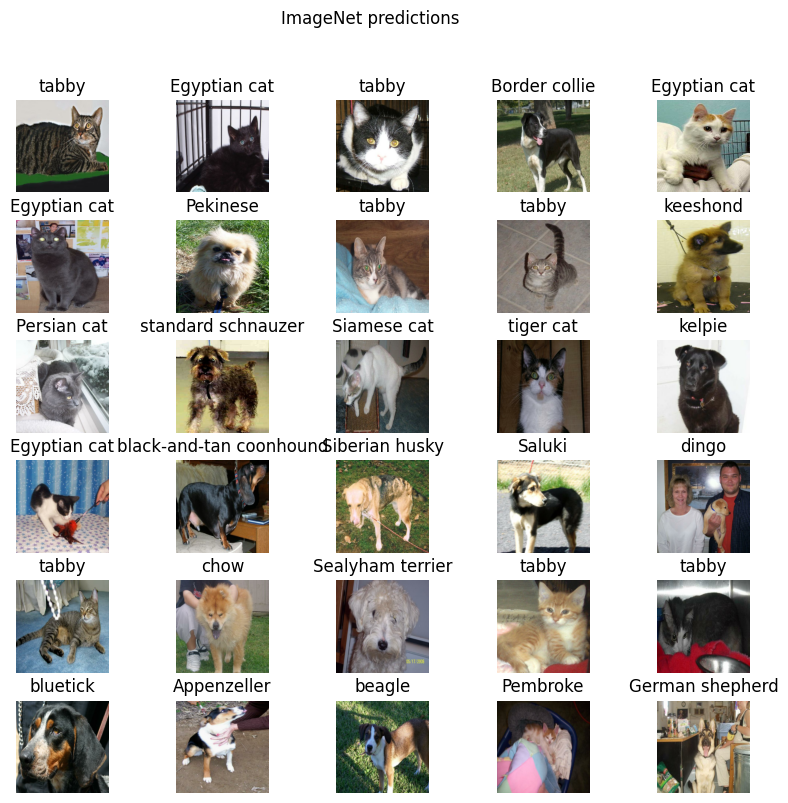

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

###Let's now use TensorFlow Hub to do Transfer Learning.

In [15]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

Let's run a batch of images through this, and see the final shape. 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [16]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [17]:
feature_extractor.trainable = False

## Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [18]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


##We now train this model like any other, by first calling `compile` followed by `fit`.

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 47s 64ms/step - loss: 0.0542 - accuracy: 0.9808 - val_loss: 0.0334 - val_accuracy: 0.9886
Epoch 2/6
582/582 [==============================] - 39s 57ms/step - loss: 0.0303 - accuracy: 0.9896 - val_loss: 0.0314 - val_accuracy: 0.9901
Epoch 3/6
582/582 [==============================] - 38s 56ms/step - loss: 0.0239 - accuracy: 0.9918 - val_loss: 0.0307 - val_accuracy: 0.9899
Epoch 4/6
582/582 [==============================] - 38s 56ms/step - loss: 0.0217 - accuracy: 0.9930 - val_loss: 0.0311 - val_accuracy: 0.9901
Epoch 5/6
582/582 [==============================] - 43s 64ms/step - loss: 0.0201 - accuracy: 0.9929 - val_loss: 0.0317 - val_accuracy: 0.9908
Epoch 6/6
582/582 [==============================] - 43s 65ms/step - loss: 0.0173 - accuracy: 0.9945 - val_loss: 0.0325 - val_accuracy: 0.9901


##plot the training and validation accuracy/loss graphs.

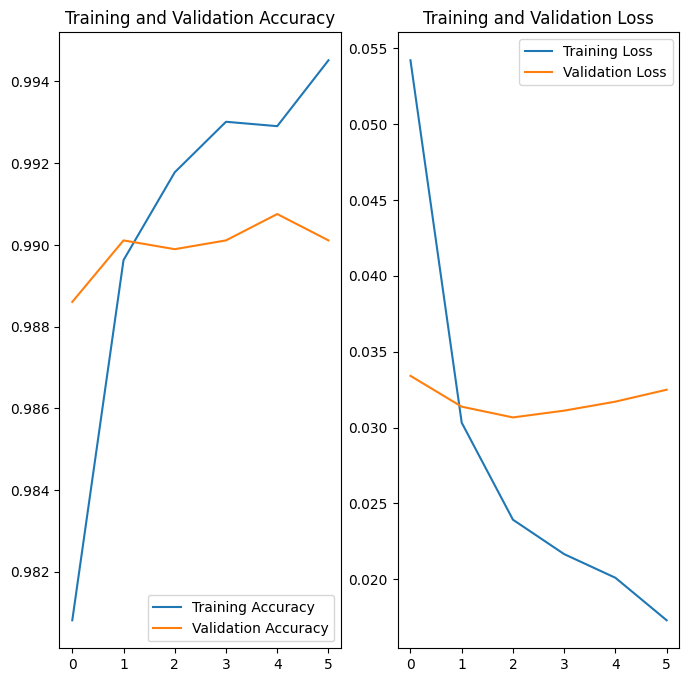

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Check the predictions

To redo the plot from before, first get the ordered list of class names.

In [21]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Run the image batch through the model and convert the indices to class names.

In [22]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 0s 494ms/step


array(['cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat',
       'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog',
       'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog',
       'dog', 'cat', 'dog', 'cat', 'cat'], dtype='<U3')

Let's look at the true labels and predicted ones.



In [23]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 0]
Predicted labels:  [0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 0]


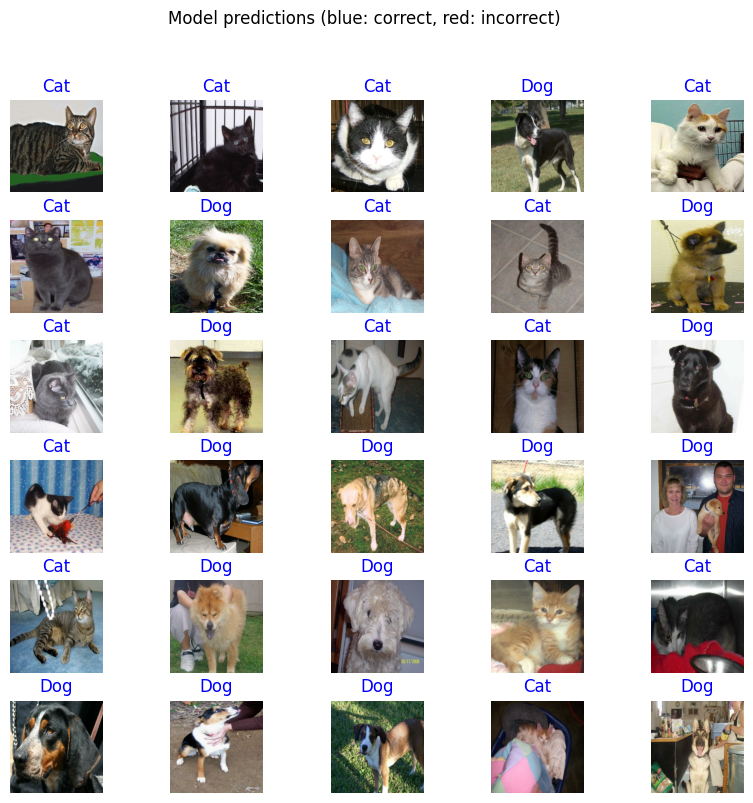

In [24]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")